In [7]:
pip install transformers


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset,Subset
from transformers import BertModel, AutoTokenizer
import tensorflow as tf
import torch.utils.data
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

In [13]:
df1 = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/data/text/train.xlsx') #데이터 다운 첫번째것은 train 두번째 것은 test
df2 = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/data/text/test.xlsx')

In [22]:
class classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(768, 256)
        self.fc2 = nn.Linear(256,1 )
        self.activation1=nn.ReLU()  #첫번째 활성화 함수 relu 두번째는 출력쪽이기 때문에 sigmoid 사용(이진분류이므로)
        self.activation2 = nn.Sigmoid()
        self.plist=[]
        self.llist=[]
        
    def forward(self, x,a): #a를 넣은 것은 이제 dropout을 평가할 때 안하기 위해서 상수를 넣었다.
        x = self.fc1(x)
        x = self.activation1(x)
        if (a==1):
          x = nn.Dropout(p=0.2)(x)
        x = self.fc2(x)
        x = self.activation2(x)
        return x

    def train(self,model,train_loader, criterion, optimizer):
        loss = None # loss of final epoch
  
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.to(device)
        model = BertModel.from_pretrained('bert-base-uncased').to(device) #bert model 설정.id , mask,toke, 이 세개를 넣어서 2개를 넣어서 model을 돌리면 두개가 결과값으로 나오고 그중 2번째걸사용
        for input_ids,attention_masks,token_type_ids, labels in train_loader: 
          input_ids = input_ids.to(device)
          token_type_ids=token_type_ids.to(device)
          attention_masks=attention_masks.to(device)
          labels = labels.to(device)
          inputs=model(input_ids,token_type_ids,attention_masks)[1].to(device) #bert를 이용하여 이제 input vector로 만들었다. 2번째 꺼 사용.
          optimizer.zero_grad() #먼저 optimizer zero로 만들어줌,
          outputs = self.forward(inputs,1) #여기서 이제 forward로 y값 입력 후 이제 그것과 loss를 비교.
          loss = criterion(outputs, labels)
          loss.backward() #backward라는 함수로 미분 뒤로 하는 것을 자동으로 해준다.
          optimizer.step()
        print(f'Loss: {loss.item():.4f}')  
        self.llist.append(loss.item())
                  
    def evaluate(self,model,test_loader):
        correct = 0
        total = 0
        s=0
        predicted_labels = []
        real_labels = []
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.to(device)
        model = BertModel.from_pretrained('bert-base-uncased').to(device)
        with torch.no_grad():
            for input_ids,attention_masks,token_type_ids, labels in test_loader:
                input_ids = input_ids.to(device)
                token_type_ids=token_type_ids.to(device)
                attention_masks=attention_masks.to(device)
                labels = labels.to(device)
                inputs=model(input_ids,token_type_ids,attention_masks)[1].to(device)
                outputs = self.forward(inputs,0)
                predicted = torch.round(outputs-0.05)                   #임계값 조절을 반올림하는 값을 수정하면서 0.55로 수정하는 효과를 냈다.
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                predicted_labels.append(predicted.cpu().numpy())                     #리스트에 저장하고 이것을 반환.
                real_labels.extend(labels.cpu().numpy())
                
        predicted_labels = np.concatenate(predicted_labels, axis=0)
        real_labels = np.array(real_labels)
        print(f'Accuracy: {100 * correct / total:.2f}%')
        self.plist.append(100 * correct / total)
        print("Correct:", correct, "Total:", total)

        target_names = ['class 0', 'class 1']
        print(classification_report(real_labels, predicted_labels, target_names=target_names))      #classification report
        
        roc_auc=roc_auc_score(real_labels, predicted_labels)                      #ROC AUC Score
        print("ROC-AUC Score: %.4f"%roc_auc)

        fpr, tpr, thresholds=roc_curve(real_labels, predicted_labels)             #ROC Curve 시각화
        plt.plot(fpr, tpr)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.show()
        #acc = sum(predicted_labels == torch.Tensor(real_labels)).item()/5000
        #print(f'Accuracy: {acc:.4f}%')
        return predicted_labels




In [18]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')  #bert token화 

train_x = df1['x']
train_y = df1['y']
encoded_texts= []
for text in train_x:
    encoded_text = tokenizer(text, return_tensors='pt', max_length=512, padding='max_length') #512가 최대이기 때문에 512로 먼저 token화를 해준다. 그리고 그걸 train과 test 따로 저장해준다.
    encoded_texts.append(encoded_text)
label=torch.tensor(train_y,dtype=torch.float)
label = torch.unsqueeze(label, dim=1)

input_ids = torch.cat([x['input_ids'] for x in encoded_texts], dim=0)
attention_masks = torch.cat([x['attention_mask'] for x in encoded_texts], dim=0)
token_type_ids = torch.cat([x['token_type_ids'] for x in encoded_texts], dim=0)
label=torch.tensor(train_y,dtype=torch.float)
label = torch.unsqueeze(label, dim=1)
train_dataset = TensorDataset(input_ids, attention_masks,token_type_ids,label)
train_loader = DataLoader(train_dataset,batch_size=1,shuffle=True)   #지금은 사람이쓴글과 gpt가 쓴 글이 안섞여있어서 섞어서 훈련을 시켜줘야 한다.



test_x = df2['x']
test_y = df2['y']
encoded_texts = []
for text in test_x:
    encoded_text = tokenizer(text, return_tensors='pt', max_length=512, padding='max_length')
    encoded_texts.append(encoded_text)
input_ids = torch.cat([x['input_ids'] for x in encoded_texts], dim=0)
attention_masks = torch.cat([x['attention_mask'] for x in encoded_texts], dim=0)
token_type_ids = torch.cat([x['token_type_ids'] for x in encoded_texts], dim=0)
label=torch.tensor(test_y,dtype=torch.float)
label = torch.unsqueeze(label, dim=1)
test_dataset = TensorDataset(input_ids, attention_masks,token_type_ids,label)
test_loader = DataLoader(test_dataset,batch_size=1,shuffle=False)   #실제 모델 평가할 때 이걸 이용하면 편하다. 왜냐면 사람이쓴것과 gpt가 쓴 것이 250개 250개 나누어져 있어서 편하다.
val_loader = DataLoader(test_dataset,batch_size=1,shuffle=True)  #이것은 모델 만드는 과정에서 정확한지 보기 위해 사용 



In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BertModel.from_pretrained('bert-base-uncased').to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Loss: 0.2096


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Accuracy: 91.60%
Correct: 458 Total: 500
              precision    recall  f1-score   support

     class 0       0.86      0.99      0.92       250
     class 1       0.99      0.84      0.91       250

    accuracy                           0.92       500
   macro avg       0.92      0.92      0.92       500
weighted avg       0.92      0.92      0.92       500

ROC-AUC Score: 0.9160


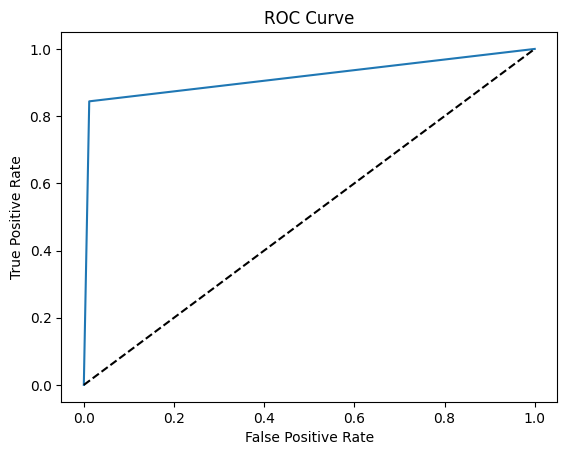

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Loss: 0.0000


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Accuracy: 97.60%
Correct: 488 Total: 500
              precision    recall  f1-score   support

     class 0       1.00      0.96      0.98       250
     class 1       0.96      1.00      0.98       250

    accuracy                           0.98       500
   macro avg       0.98      0.98      0.98       500
weighted avg       0.98      0.98      0.98       500

ROC-AUC Score: 0.9760


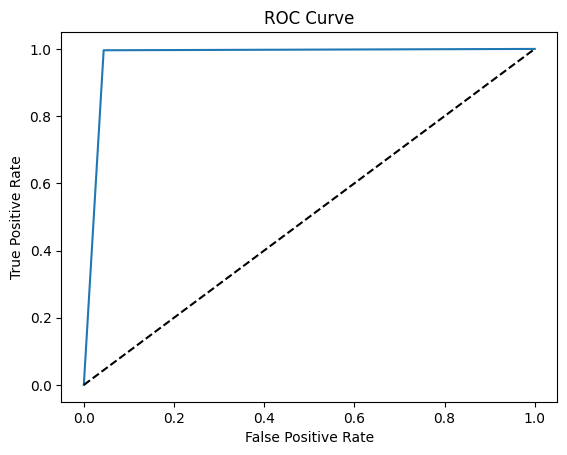

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Loss: 0.2456


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Accuracy: 87.20%
Correct: 436 Total: 500
              precision    recall  f1-score   support

     class 0       0.80      0.99      0.89       250
     class 1       0.98      0.76      0.86       250

    accuracy                           0.87       500
   macro avg       0.89      0.87      0.87       500
weighted avg       0.89      0.87      0.87       500

ROC-AUC Score: 0.8720


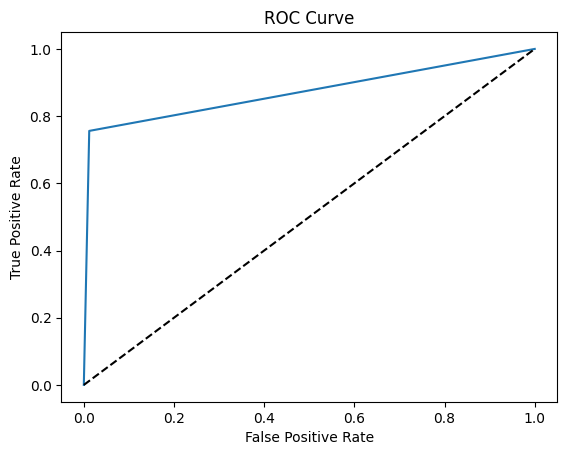

In [23]:
classfication =classifier()
num_epochs=3      #논문에서는 num_epochs를 10으로 조정
criterion = nn.BCELoss()
tensor = torch.zeros(500)
optimizer = optim.Adam(classfication.parameters(), lr=0.001)
for i in range(num_epochs): #학습. 
  classfication.train(model,train_loader,criterion, optimizer)
  current=classfication.evaluate(model,test_loader) 
  

In [ ]:
tensor_list = [tensor_item.item() for tensor_item in current] #tesnor값을 그냥 int list로 변환

In [ ]:
a=0
b=0
for i in range(500):
  if i<250:
    if (tensor_list[i]==1):
      a=a+1  #FP
  else:
    if (tensor_list[i]==1):
      b=b+1  #TP

#정확도는 이제 a+b/500


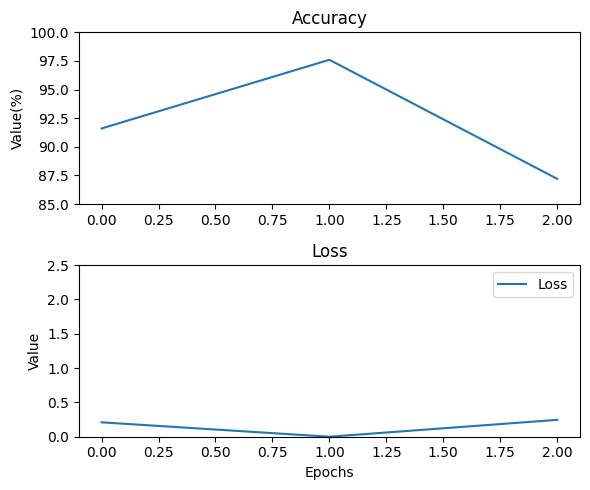

In [25]:
#정확도 loss 시각화
plt.figure(figsize=(6,5))
plt.subplot(2,1,1)
plt.title('Accuracy')
plt.ylim(85, 100)
plt.plot(classfication.plist, label='Accuracy')
#plt.plot(plist, label='%')
plt.ylabel('Value(%)')

plt.subplot(2,1,2)
plt.ylim(0, 2.5)
plt.plot(classfication.llist, label='Loss')
#plt.plot(llist)
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()

plt.tight_layout()
plt.show()